In [1]:
import sys
from basic_utils import *
from option_recommendations import *

Loading config.json


In [2]:
symbol = 'ALLO'
interval = '1m'
prange = '5d'
data = get_pricing(symbol, interval, prange)

Getting pricing interval of ALLO interval: 1m, range: 5d


In [7]:
data_dict = json.loads(data)
print(data_dict.keys())
data_dict['meta']
dates = [datetime.fromtimestamp(x) for x in data_dict['timestamp']]
indicators_quote_0 = data_dict['indicators']['quote'][0]
H = indicators_quote_0['high']
L = indicators_quote_0['low']
O = indicators_quote_0['open']
C = indicators_quote_0['close']
V = indicators_quote_0['volume']

dict_keys(['meta', 'timestamp', 'indicators'])


In [8]:
price_dict = {'high': H,'low': L,'open': O,'close' : C, 'volume': V}
df = pd.DataFrame(price_dict, index=dates)

In [9]:
df

,high,low,open,close,volume
2019-01-11 06:30:00,331.329987,328.586792,331.100006,329.295013,736626
2019-01-11 06:31:00,330.720001,329.440002,329.440002,330.000000,173308
2019-01-11 06:32:00,330.980011,328.760010,330.130005,330.040009,162539
2019-01-11 06:33:00,331.799988,329.690002,330.000000,331.700012,150813
2019-01-11 06:34:00,334.000000,331.609985,331.609985,333.186401,282330
2019-01-11 06:35:00,334.019897,332.850006,333.329987,333.790009,224481
2019-01-11 06:36:00,334.880005,333.329987,333.850006,333.788513,208767
2019-01-11 06:37:00,333.042114,331.940002,332.940002,332.498993,172799
2019-01-11 06:38:00,332.828094,331.500000,332.505005,331.500000,105505
2019-01-11 06:39:00,331.510010,330.460114,331.411011,331.120697,105076


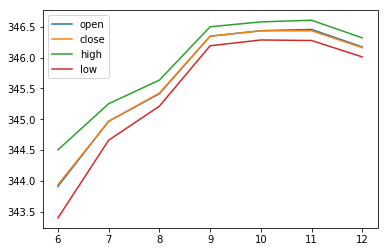

In [18]:
fields = ['open', 'close', 'high', 'low']
# fields = ['volume']
tgt_df = df[fields]
tgt_df.groupby(tgt_df.index.hour).mean().plot()
# tgt_df.plot()